In [9]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch 
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow import keras

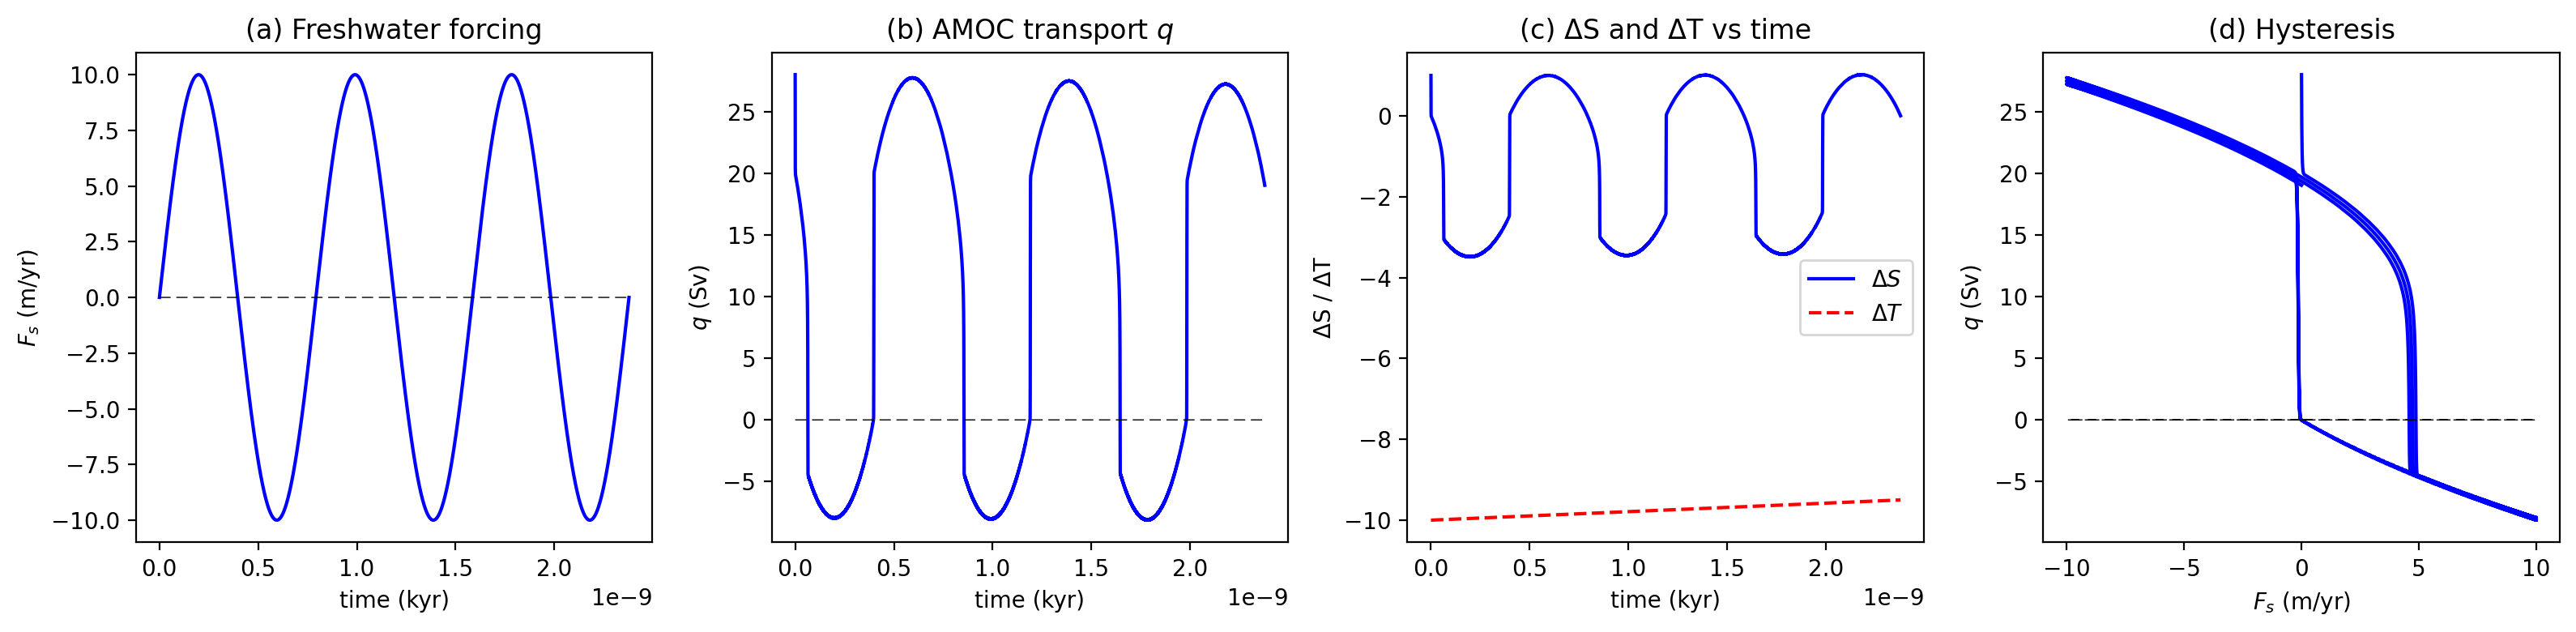

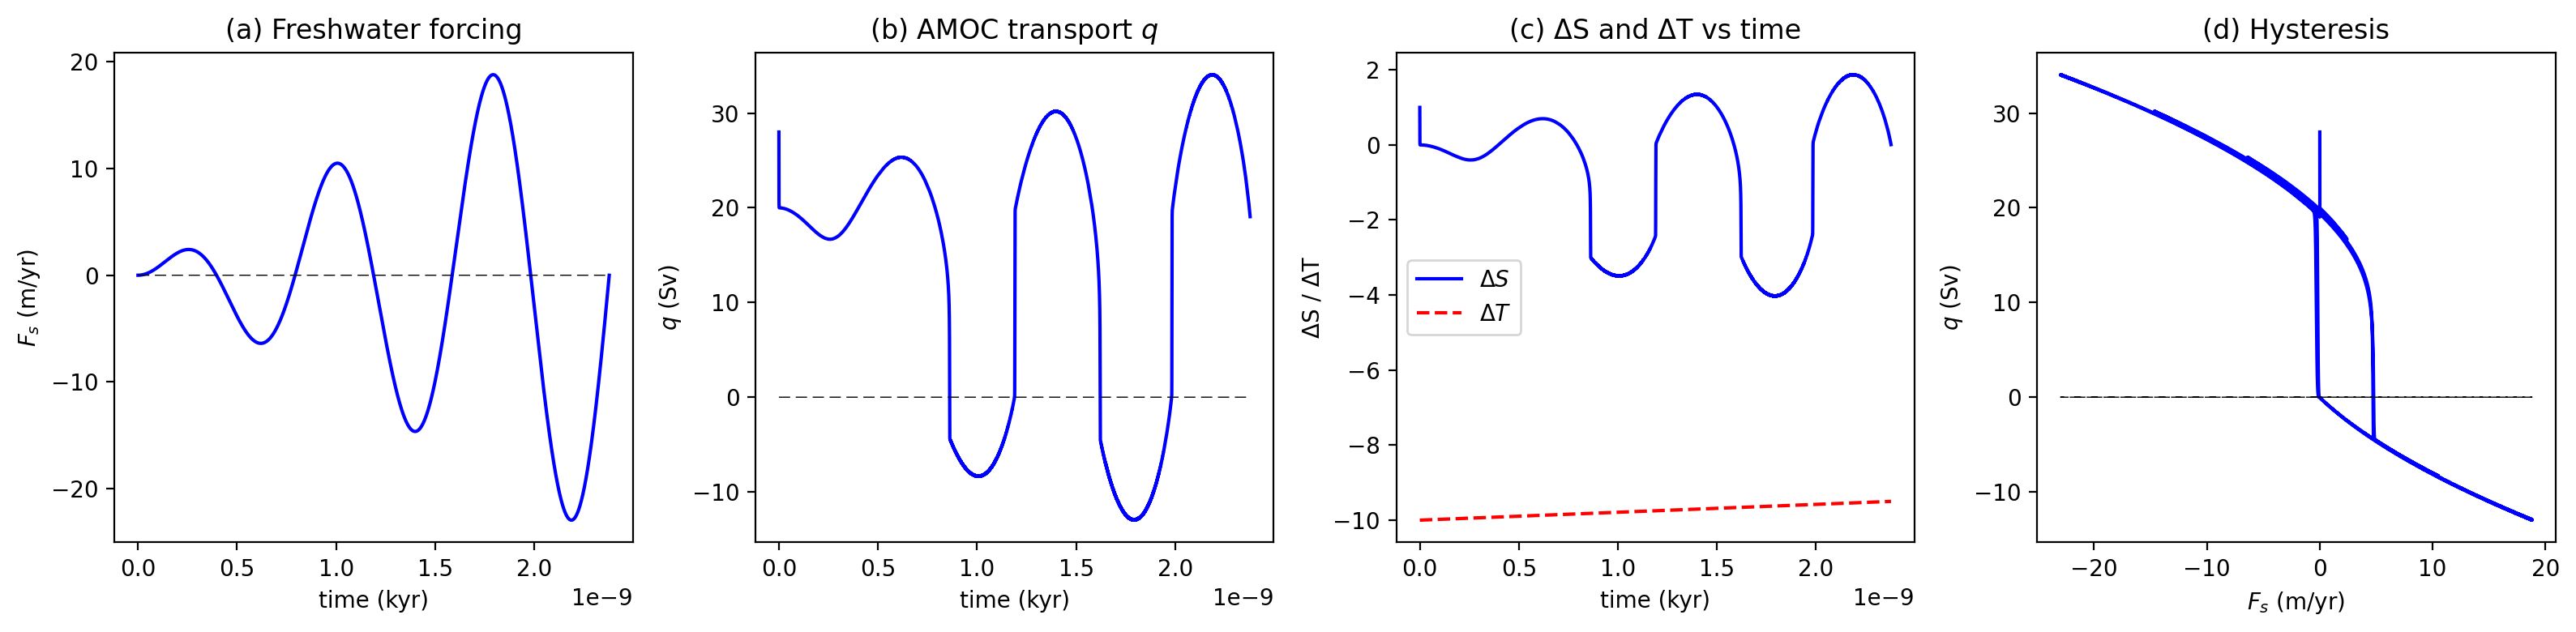

In [2]:
%run 00_generate_data.ipynb

In [3]:
input_data, output_data, qplot = get_data("s")

# TRAINING

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [5]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
lstm = keras.models.load_model("models/lstm/stationary/ensemble_member_0.keras")

OSError: No file or directory found at models/lstm/stationary/ensemble_member_0.keras

In [ ]:
class LSTMForLRP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x, use_logits=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if not use_logits:
            x = self.sigmoid(x)
        return x

model = MLP()

In [7]:
criterion = nn.BCELoss()  # binary_crossentropy equivalent
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/10, Train Loss: 0.4598, Val Loss: 0.2077
Epoch 2/10, Train Loss: 0.1766, Val Loss: 0.0922
Epoch 3/10, Train Loss: 0.0843, Val Loss: 0.0441
Epoch 4/10, Train Loss: 0.0453, Val Loss: 0.0234
Epoch 5/10, Train Loss: 0.0274, Val Loss: 0.0137
Epoch 6/10, Train Loss: 0.0189, Val Loss: 0.0091
Epoch 7/10, Train Loss: 0.0146, Val Loss: 0.0064
Epoch 8/10, Train Loss: 0.0122, Val Loss: 0.0049
Epoch 9/10, Train Loss: 0.0106, Val Loss: 0.0037
Epoch 10/10, Train Loss: 0.0095, Val Loss: 0.0030


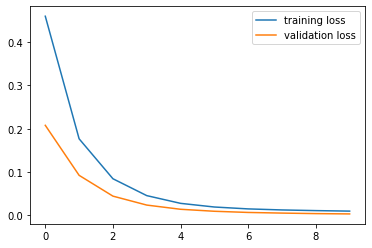

In [8]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [9]:
model.eval() 

MLP(
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [10]:
with torch.no_grad():
    probs = model(input_tensor)        

In [11]:
predictions = probs.numpy() 

In [14]:
predicted_labels = (predictions.squeeze() > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_data)

In [39]:
accuracy = (1 - len(np.where(false_indices[0] >= 81992)[0])/len(y_test))*100
print(accuracy)

97.74544646823634


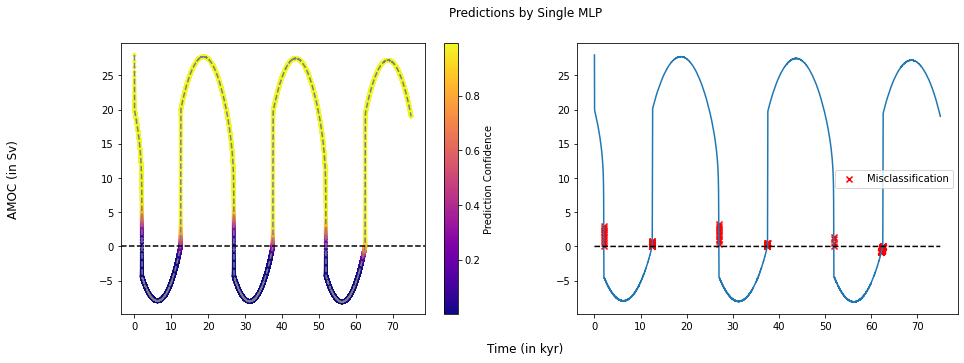

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
sc = ax[0].scatter(input_data[:, 0], qplot/Sv, c=predictions, cmap='plasma', s=10);
ax[0].plot(input_data[:, 0], qplot / Sv, color="grey", linestyle="--");
ax[0].axhline(y=0, color='black', linestyle='dashed');
fig.colorbar(sc, ax=ax[0], label="Prediction Confidence");
ax[1].plot(input_data[:, 0], qplot/Sv);
ax[1].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--');
ax[1].scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red', label='Misclassification');
fig.suptitle('Predictions by Single MLP');
fig.supxlabel('Time (in kyr)');
fig.supylabel('AMOC (in Sv)');
plt.legend();

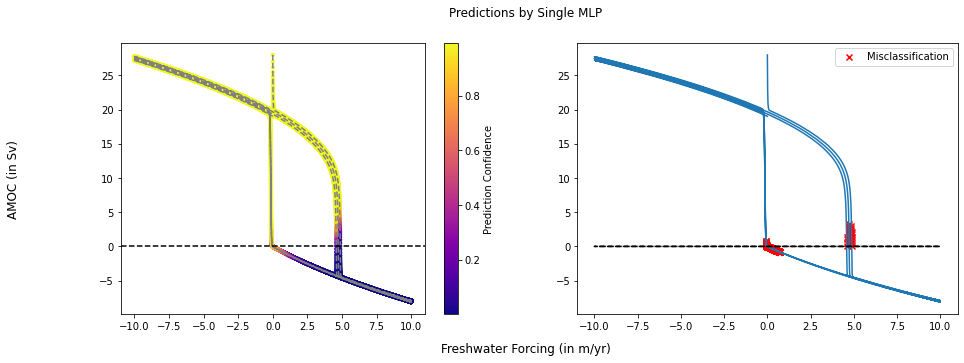

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
sc = ax[0].scatter(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, c=predictions, cmap='plasma', s=10);
ax[0].plot(input_data[:, 3]/Fs_to_m_per_year, qplot / Sv, color="grey", linestyle="--");
ax[0].axhline(y=0, color='black', linestyle='dashed');
fig.colorbar(sc, ax=ax[0], label="Prediction Confidence");
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 3]), 'k--');
ax[1].scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red', label='Misclassification');
fig.suptitle('Predictions by Single MLP');
fig.supxlabel('Freshwater Forcing (in m/yr)');
fig.supylabel('AMOC (in Sv)');
plt.legend();

# SHAP

In [46]:
import shap

In [52]:
def model_pred(x):
    model.eval() 
    with torch.no_grad():
        probs = model(x)
    return probs

In [78]:
# More samples where AMOC changes rapidly (derivatives)
qplot_smooth = qplot/Sv
q_gradient = np.abs(np.gradient(qplot_smooth))

# Higher sampling probability where gradient is high

gradient_probs = q_gradient / q_gradient.sum()
np.random.seed(42)
sample_indices = np.random.choice(len(qplot), size=200, replace=False, p=gradient_probs)

In [79]:
raw_input_sample = input_data[sample_indices]
qsample = qplot[sample_indices]

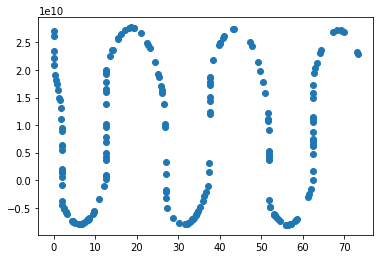

In [80]:
plt.scatter(raw_input_sample[:, 0], qsample)

In [81]:
np.random.seed(123)  # fix the seed for reproducibility

num_background = 100
background_data = shap.sample(X_train_tensor, nsamples=num_background)

In [82]:
feature_names = ['Time', 'Salinity Difference', 'Temperature Difference', 'Freshwater Forcing']
input_sample = input_tensor[sample_indices]

In [83]:
explainer = shap.GradientExplainer(model, background_data)
shap_values = explainer.shap_values(input_sample)

In [84]:
shap_values.shape

(200, 4)

In [85]:
shap_sal = shap_values[:, 1]
shap_temp = shap_values[:, 2]

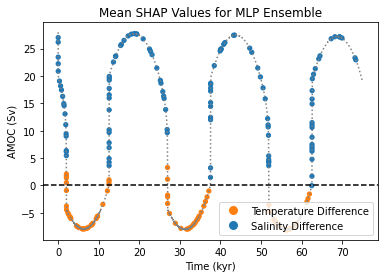

In [86]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(shap_temp > shap_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(raw_input_sample[:, 0], qsample/Sv, 
                    c=colors, marker='o', s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean SHAP Values for MLP Ensemble')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

# LRP

In [112]:
from captum.attr import LRP, LayerLRP

In [124]:
import torch
import torch.nn as nn
from captum.attr import LRP

# Your working model structure (separate ReLU instances)
class MLPForLRP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(4, 2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the LRP-compatible model
lrp_model = MLPForLRP()

# Copy weights from your trained PyTorch model
lrp_model.fc1.weight.data = model.fc1.weight.data.clone()
lrp_model.fc1.bias.data = model.fc1.bias.data.clone()
lrp_model.fc2.weight.data = model.fc2.weight.data.clone()
lrp_model.fc2.bias.data = model.fc2.bias.data.clone()
lrp_model.fc3.weight.data = model.fc3.weight.data.clone()
lrp_model.fc3.bias.data = model.fc3.bias.data.clone()

lrp_model.eval()

# Run LRP
x = torch.tensor(input_scaled, dtype=torch.float32)
lrp = LRP(lrp_model)
attributions = lrp.attribute(x)
attributions_np = attributions.detach().numpy()

print("LRP shape:", attributions_np.shape)

Input Tensor 0 did not already require gradients, required_grads has been set automatically.


LRP shape: (100000, 4)


In [125]:
lrp = attributions_np

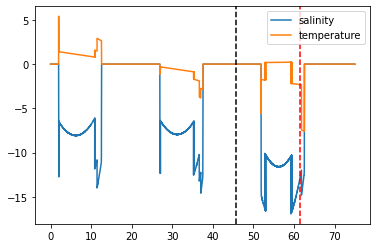

In [128]:
plt.plot(input_data[:, 0], lrp[:, 1], label='salinity')
plt.plot(input_data[:, 0], lrp[:, 2], label='temperature')
plt.axvline(x=input_data[81992, 0], color='red', linestyle='dashed')
plt.axvline(x=input_data[61024, 0], color='black', linestyle='dashed')
plt.legend()